In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
df = pd.read_json('transactions.txt', lines=True)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## Data Cleaning

In [3]:
# Replacing white space with nan

df = df.replace('', np.nan)

C:\Users\brian\AppData\Local\Temp\ipykernel_43956\2814523631.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)


In [4]:
# Checking which columns are empty and removing

nan_col = df.columns[df.isna().all()].tolist()
df.drop(columns=nan_col, inplace=True)

print("Empty columns that were removed:")
print(nan_col)

Empty columns that were removed:
['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [5]:
# Account Number and Customer Id columns appear to be equal

df['accountNumber'].equals(df['customerId'])

True

In [6]:
# Removing customerId as it is a duplicate of accountNumber

df.drop(columns=['customerId'], inplace=True)

In [7]:
# Dropping merchantName as merchantCategory will be used
df.drop(columns=['merchantName'], inplace=True)

In [8]:
# Need to remove remaining unneeded columns
#df.drop(columns=['cardCVV'], inplace=True)
#df.drop(columns=['enteredCVV'], inplace=True)
df.drop(columns=['cardLast4Digits'], inplace=True)

In [9]:
# Filling NaN with purchase to keep data

df['transactionType'] = df['transactionType'].fillna('PURCHASE')

In [10]:
# Total amount of rows with NaN values
df.isnull().any(axis=1).sum()

9003

In [11]:
# Dropping all rows with NaN value
df = df.dropna()

In [12]:
pd.pandas.set_option('display.max_columns', None)

In [13]:
# Changing transactionDatetime. All transactions occurred in 2016, year is unneeded.

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['Month'] = df['transactionDateTime'].dt.month
df['day'] = df['transactionDateTime'].dt.day
df['hour'] = df['transactionDateTime'].dt.hour
df['minute'] = df['transactionDateTime'].dt.minute

# Cyclic encoding for hour and minute
df['hourSin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hourCos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minuteSin'] = np.sin(2 * np.pi * df['minute'] / 24)
df['minuteCos'] = np.cos(2 * np.pi * df['minute'] / 24)

# Do not need columns
df.drop(columns=['transactionDateTime'], inplace=True)
df.drop(columns=['hour'], inplace=True)
df.drop(columns=['minute'], inplace=True)

In [14]:
# Reformatting other date columns

df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month

df['accountOpenYear'] = pd.to_datetime(df['accountOpenDate']).dt.year
df['accountOpenMonth'] = pd.to_datetime(df['accountOpenDate']).dt.month
df['accountOpenDay'] = pd.to_datetime(df['accountOpenDate']).dt.day

df['lastAddressChangeYear'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.year
df['lastAddressChangeMonth'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.month
df['lastAddressChangeDay'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.day

# removing unneeded columns
df.drop(columns=['currentExpDate'], inplace=True)
df.drop(columns=['accountOpenDate'], inplace=True)
df.drop(columns=['dateOfLastAddressChange'], inplace=True)

C:\Users\brian\AppData\Local\Temp\ipykernel_43956\3371426977.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
C:\Users\brian\AppData\Local\Temp\ipykernel_43956\3371426977.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month


## Encoding

In [15]:
# Categorical columns that need to be endocded

columns_to_encode = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'merchantCategoryCode']
df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Convert boolean columns to integers
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777360 entries, 0 to 786362
Data columns (total 62 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   accountNumber                              777360 non-null  int64  
 1   creditLimit                                777360 non-null  int64  
 2   availableMoney                             777360 non-null  float64
 3   transactionAmount                          777360 non-null  float64
 4   cardCVV                                    777360 non-null  int64  
 5   enteredCVV                                 777360 non-null  int64  
 6   currentBalance                             777360 non-null  float64
 7   cardPresent                                777360 non-null  int32  
 8   expirationDateKeyInMatch                   777360 non-null  int32  
 9   isFraud                                    777360 non-null  bool   
 10  Month        

In [17]:
# Breaking apart features and labels

features = df.iloc[:, :-1]
labels = df['isFraud']

## Splitting dataset into train, test and val

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

np.random.seed(33)
tf.random.set_seed(33)

X = df.drop('isFraud', axis = 1)
Y = df['isFraud']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=33, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=33, stratify=y_temp)


In [19]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize numerical features
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns
ct = ColumnTransformer([("only numeric", MinMaxScaler(), numerical_columns)], remainder='passthrough')

#Fit instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train)
x_train_scaled = x_train_scaled.astype('float32')
x_test_scaled = ct.transform(x_test)
x_test_scaled = x_test_scaled.astype('float32')
x_val_scaled = ct.transform(x_val)
x_val_scaled = x_val_scaled.astype('float32')

## Testing Function

In [20]:
# Function to test the model and produce results
'''
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def test_metrics(model, x_test, y_test):

    #predict probabilities
    y_pred = model.predict(x_test)

    #Convert probs intobinary predictions
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)

    #Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    #Print metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc)
    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)
'''

'\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay\n\ndef test_metrics(model, x_test, y_test):\n\n    #predict probabilities\n    y_pred = model.predict(x_test)\n\n    #Convert probs intobinary predictions\n    threshold = 0.5\n    y_pred_binary = (y_pred >= threshold).astype(int)\n\n    #Calculate metrics\n    accuracy = accuracy_score(y_test, y_pred_binary)\n    precision = precision_score(y_test, y_pred_binary)\n    recall = recall_score(y_test, y_pred_binary)\n    f1 = f1_score(y_test, y_pred_binary)\n\n    # ROC and AUC\n    fpr, tpr, _ = roc_curve(y_test, y_pred)\n    auc = roc_auc_score(y_test, y_pred)\n\n    #Confusion Matrix\n    cm = confusion_matrix(y_test, y_pred_binary)\n\n    #Print metrics\n    print("Accuracy:", accuracy)\n    print("Precision:", precision)\n    print("Recall:", recall)\n    print("F1-Score:", f1)\n    print("AUC:", auc)\n    print("Confusion Matrix:"

In [21]:
# Function to test the model threshold to procude the best f1 score and produce results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def test_metrics(model, x_test, y_test):
    y_pred = model.predict(x_test)

    # Find the best threshold for F1 score
    thresholds = np.linspace(0, 1, 100)
    f1_scores = []
    for thresh in thresholds:
        y_pred_binary = (y_pred >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred_binary)
        f1_scores.append(f1)
    
    # Get the best threshold
    max_f1_index = np.argmax(f1_scores) 
    best_threshold = thresholds[max_f1_index]
    best_f1 = f1_scores[max_f1_index]

    # Use the best threshold to get final predictions
    y_pred_binary = (y_pred >= best_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred_binary)

    # Print metrics
    print(f"Best Threshold: {best_threshold}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {best_f1}")
    print(f"AUC: {auc}")
    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)

    metrics = {
        'Best Threshold': best_threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': best_f1,
        'AUC': auc,
        'Confusion Matrix': cm
    }
    return metrics
    

## Model Creation

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.random.seed(33)
tf.random.set_seed(33)

model_1 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
model_1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [24]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_1.fit(x_train_scaled, y_train, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10

17005/17005 [==============================] - 21s 1ms/step - loss: 0.2278 - binary_accuracy: 0.9827 - recall: 0.0021 - val_loss: 0.0798 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 2/10
17005/17005 [==============================] - 20s 1ms/step - loss: 0.0797 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0760 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 3/10
17005/17005 [==============================] - 20s 1ms/step - loss: 0.0783 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0765 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 4/10
17005/17005 [==============================] - 20s 1ms/step - loss: 0.0775 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0767 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 5/10
17005/17005 [==============================] - 20s 1ms/step - loss: 0.0771 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0787 - val_binary_accuracy: 

3644/3644 [==============================] - 3s 708us/step
Best Threshold: 0.04040404040404041
Accuracy: 0.9545212857191863
Precision: 0.06801379990142928
Recall: 0.15358931552587646
F1-Score: 0.09427839453458582
AUC: 0.7318980334754446
Confusion Matrix:
[[111025   3782]
 [  1521    276]]


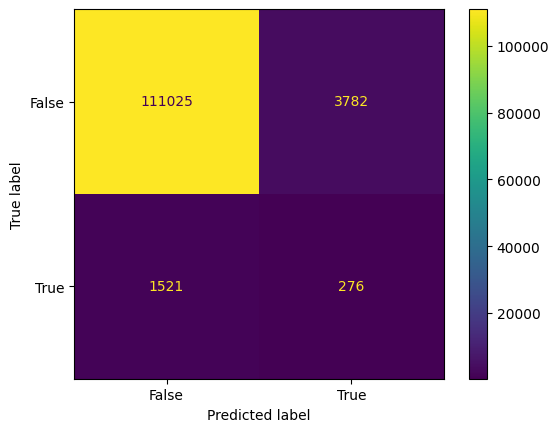

In [25]:
m1_test_results = test_metrics(model_1, x_test_scaled, y_test)

## Model Creation with SMOTE

In [26]:
np.random.seed(33)
tf.random.set_seed(33)
# Applying SMOTE to address the class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=33)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [28]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize numerical features

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns # Get a list of the column names
ct = ColumnTransformer([("only numeric", MinMaxScaler(), numerical_columns)], remainder='passthrough')

#Fit instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train_resampled)
x_train_scaled = x_train_scaled.astype('float32')
x_test_scaled = ct.transform(x_test)
x_test_scaled = x_test_scaled.astype('float32')
x_val_scaled = ct.transform(x_val)
x_val_scaled = x_val_scaled.astype('float32')

In [29]:
np.random.seed(33)
tf.random.set_seed(33)

model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [30]:
model_2.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [31]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_2.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.6865 - binary_accuracy: 0.7997 - recall_1: 0.7901 - val_loss: 0.0918 - val_binary_accuracy: 0.9839 - val_recall_1: 0.0100
Epoch 2/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.2820 - binary_accuracy: 0.8847 - recall_1: 0.8552 - val_loss: 0.8076 - val_binary_accuracy: 0.5461 - val_recall_1: 0.7574
Epoch 3/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.2477 - binary_accuracy: 0.8996 - recall_1: 0.8445 - val_loss: 0.1885 - val_binary_accuracy: 0.9842 - val_recall_1: 0.0028
Epoch 4/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.2444 - binary_accuracy: 0.9004 - recall_1: 0.8334 - val_loss: 0.1553 - val_binary_accuracy: 0.9814 - val_recall_1: 0.0167
Epoch 5/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.2355 - binary_accuracy: 0.9048 - recall_1: 0.8381 - val_loss: 0.2574 - val_binary_accuracy: 0.9535 - val_re

3644/3644 [==============================] - 3s 683us/step
Best Threshold: 0.31313131313131315
Accuracy: 0.9520942677781208
Precision: 0.0653819683413627
Recall: 0.15859766277128548
F1-Score: 0.09259259259259259
AUC: 0.7186628286801948
Confusion Matrix:
[[110733   4074]
 [  1512    285]]


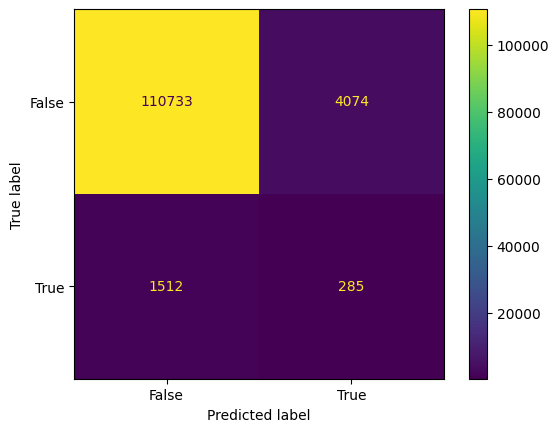

In [32]:
m2_test_results = test_metrics(model_2, x_test_scaled, y_test)

## Model 3
Adding an additional dense layer

In [33]:
np.random.seed(33)
tf.random.set_seed(33)

model_3 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
model_3.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [35]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_3.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.4286 - binary_accuracy: 0.8186 - recall_2: 0.7877 - precision: 0.8395 - val_loss: 0.1954 - val_binary_accuracy: 0.9739 - val_recall_2: 0.0746 - val_precision: 0.0887
Epoch 2/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2656 - binary_accuracy: 0.8915 - recall_2: 0.8256 - precision: 0.9509 - val_loss: 0.2685 - val_binary_accuracy: 0.9260 - val_recall_2: 0.2499 - val_precision: 0.0581
Epoch 3/10
33486/33486 [==============================] - 44s 1ms/step - loss: 0.2426 - binary_accuracy: 0.9022 - recall_2: 0.8353 - precision: 0.9644 - val_loss: 0.0879 - val_binary_accuracy: 0.9846 - val_recall_2: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
33486/33486 [==============================] - 42s 1ms/step - loss: 0.2331 - binary_accuracy: 0.9065 - recall_2: 0.8402 - precision: 0.9685 - val_loss: 0.1775 - val_binary_accuracy: 0.9794 - val_recall_2: 0.0479 - val_precision: 0.1107
Epoc

3644/3644 [==============================] - 3s 779us/step
Best Threshold: 0.4646464646464647
Accuracy: 0.9660131727899558
Precision: 0.0866412213740458
Recall: 0.12632164718976072
F1-Score: 0.10278469549467965
AUC: 0.7202035165072151
Confusion Matrix:
[[112414   2393]
 [  1570    227]]


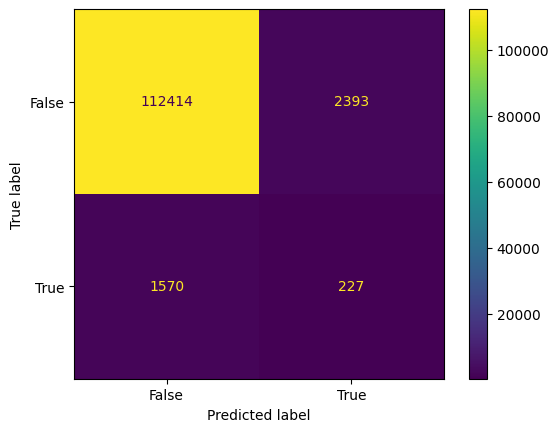

In [36]:
m3_test_results = test_metrics(model_3, x_test_scaled, y_test)

## Model 4
Testing model architecture with bias in fully connected layers

In [37]:
np.random.seed(33)
tf.random.set_seed(33)

model_4 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],), use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [38]:
model_4.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [39]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_4.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 43s 1ms/step - loss: 0.6825 - binary_accuracy: 0.5720 - recall_3: 0.5777 - precision_1: 0.5712 - val_loss: 0.6891 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 45s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_3: 0.5275 - precision_1: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 48s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4998 - recall_3: 0.4784 - precision_1: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_precision_1: 0.0154
Epoch 4/10
33486/33486 [==============================] - 49s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4992 - recall_3: 0.5338 - precision_1: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_

3644/3644 [==============================] - 3s 837us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


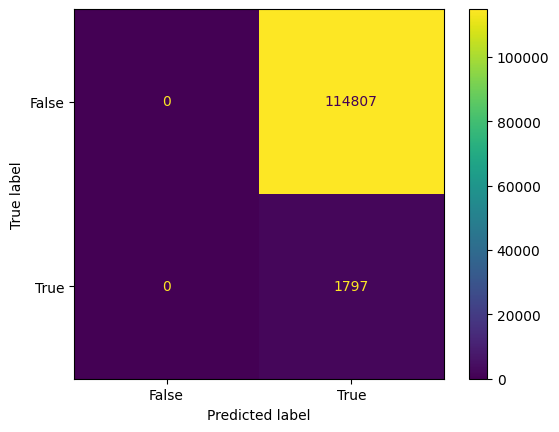

In [40]:
m4_test_results = test_metrics(model_4, x_test_scaled, y_test)

## Model 5
Adding drop out layers

In [41]:
np.random.seed(33)
tf.random.set_seed(33)

model_5 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [42]:
model_5.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [43]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_5.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 49s 1ms/step - loss: 0.8558 - binary_accuracy: 0.4996 - recall_4: 0.5199 - precision_2: 0.4996 - val_loss: 0.6896 - val_binary_accuracy: 0.9846 - val_recall_4: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 46s 1ms/step - loss: 0.6935 - binary_accuracy: 0.4994 - recall_4: 0.5265 - precision_2: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_4: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 46s 1ms/step - loss: 0.6934 - binary_accuracy: 0.4998 - recall_4: 0.4758 - precision_2: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_4: 1.0000 - val_precision_2: 0.0154
Epoch 4/10
33486/33486 [==============================] - 46s 1ms/step - loss: 0.6933 - binary_accuracy: 0.4993 - recall_4: 0.5326 - precision_2: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_4: 1.0000 - val_

3644/3644 [==============================] - 3s 826us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


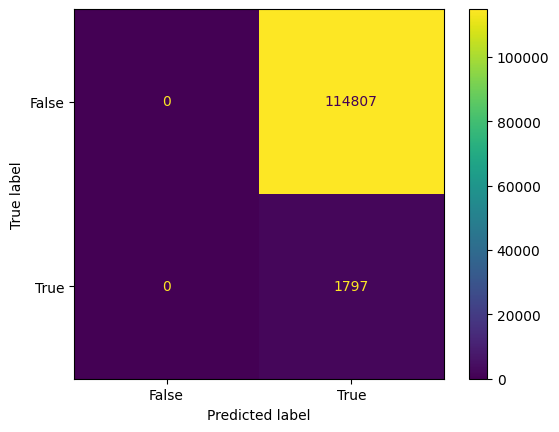

In [44]:
m5_test_results = test_metrics(model_5, x_test_scaled, y_test)

## Model 6
Switching to Leaky Relu as the activation function

In [45]:
np.random.seed(33)
tf.random.set_seed(33)

model_6 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [46]:
model_6.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [47]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_6.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 48s 1ms/step - loss: 0.5993 - binary_accuracy: 0.7638 - recall_5: 0.7152 - precision_3: 0.7921 - val_loss: 0.2039 - val_binary_accuracy: 0.9764 - val_recall_5: 0.0579 - val_precision_3: 0.0897
Epoch 2/10
33486/33486 [==============================] - 46s 1ms/step - loss: 0.2988 - binary_accuracy: 0.8697 - recall_5: 0.8018 - precision_3: 0.9277 - val_loss: 0.2654 - val_binary_accuracy: 0.9437 - val_recall_5: 0.1742 - val_precision_3: 0.0580
Epoch 3/10
33486/33486 [==============================] - 46s 1ms/step - loss: 0.2756 - binary_accuracy: 0.8819 - recall_5: 0.8147 - precision_3: 0.9411 - val_loss: 0.1532 - val_binary_accuracy: 0.9846 - val_recall_5: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 4/10
33486/33486 [==============================] - 47s 1ms/step - loss: 0.2588 - binary_accuracy: 0.8909 - recall_5: 0.8236 - precision_3: 0.9516 - val_loss: 0.1152 - val_binary_accuracy: 0.9845 - val_recall_5: 0.0011 - val_precisio

3644/3644 [==============================] - 3s 773us/step
Best Threshold: 0.38383838383838387
Accuracy: 0.9447017254982676
Precision: 0.06163996229971725
Recall: 0.18196994991652754
F1-Score: 0.09208673613066742
AUC: 0.7103432433476136
Confusion Matrix:
[[109829   4978]
 [  1470    327]]


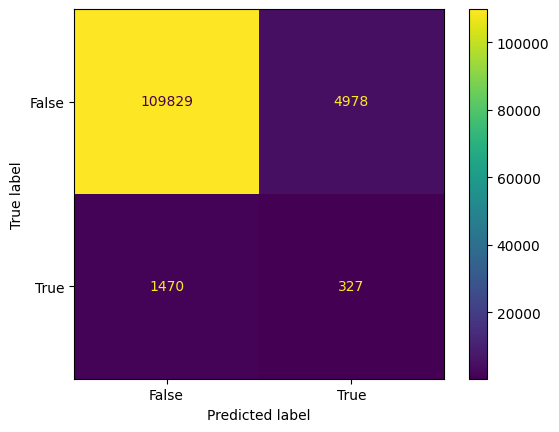

In [48]:
m6_test_results = test_metrics(model_6, x_test_scaled, y_test)

## Model 7
Adding another Dense layer

In [49]:
np.random.seed(33)
tf.random.set_seed(33)

model_7 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [50]:
model_7.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [51]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_7.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 50s 1ms/step - loss: 0.6261 - binary_accuracy: 0.6694 - recall_6: 0.6340 - precision_4: 0.6823 - val_loss: 0.2337 - val_binary_accuracy: 0.9810 - val_recall_6: 0.0267 - val_precision_4: 0.0938
Epoch 2/10
33486/33486 [==============================] - 48s 1ms/step - loss: 0.3008 - binary_accuracy: 0.8709 - recall_6: 0.8023 - precision_4: 0.9298 - val_loss: 0.1309 - val_binary_accuracy: 0.9843 - val_recall_6: 0.0028 - val_precision_4: 0.1136
Epoch 3/10
33486/33486 [==============================] - 48s 1ms/step - loss: 0.2765 - binary_accuracy: 0.8843 - recall_6: 0.8167 - precision_4: 0.9443 - val_loss: 0.1114 - val_binary_accuracy: 0.9846 - val_recall_6: 0.0000e+00 - val_precision_4: 0.0000e+00
Epoch 4/10
33486/33486 [==============================] - 49s 1ms/step - loss: 0.2617 - binary_accuracy: 0.8918 - recall_6: 0.8240 - precision_4: 0.9533 - val_loss: 0.2111 - val_binary_accuracy: 0.9833 - val_recall_6: 0.0145 - val_precisio

3644/3644 [==============================] - 3s 771us/step
Best Threshold: 0.36363636363636365
Accuracy: 0.9544784055435491
Precision: 0.06707768187422934
Recall: 0.15136338341680577
F1-Score: 0.09295967190704033
AUC: 0.7098265793912126
Confusion Matrix:
[[111024   3783]
 [  1525    272]]


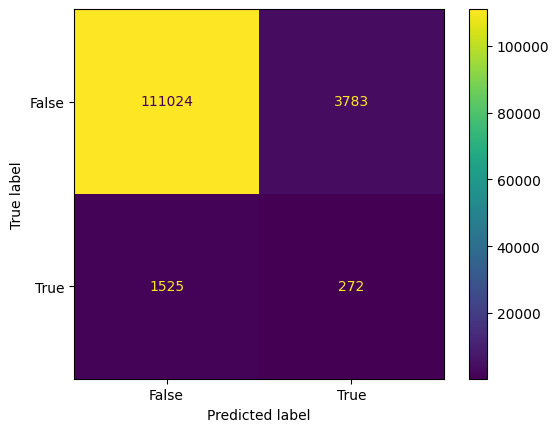

In [52]:
m7_test_results = test_metrics(model_7, x_test_scaled, y_test)

# Model 8
Adding more filters to the Dense layers

In [53]:
np.random.seed(33)
tf.random.set_seed(33)

model_8 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [54]:
model_8.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [55]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_8.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 47s 1ms/step - loss: 0.7256 - binary_accuracy: 0.6722 - recall_7: 0.6465 - precision_5: 0.6815 - val_loss: 0.2637 - val_binary_accuracy: 0.8928 - val_recall_7: 0.3189 - val_precision_5: 0.0484
Epoch 2/10
33486/33486 [==============================] - 46s 1ms/step - loss: 0.3012 - binary_accuracy: 0.8704 - recall_7: 0.8001 - precision_5: 0.9309 - val_loss: 0.2431 - val_binary_accuracy: 0.9626 - val_recall_7: 0.1252 - val_precision_5: 0.0747
Epoch 3/10
33486/33486 [==============================] - 48s 1ms/step - loss: 0.2751 - binary_accuracy: 0.8846 - recall_7: 0.8148 - precision_5: 0.9470 - val_loss: 0.1114 - val_binary_accuracy: 0.9846 - val_recall_7: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 4/10
33486/33486 [==============================] - 48s 1ms/step - loss: 0.2632 - binary_accuracy: 0.8906 - recall_7: 0.8213 - precision_5: 0.9534 - val_loss: 0.1993 - val_binary_accuracy: 0.9835 - val_recall_7: 0.0089 - val_precisio

KeyboardInterrupt: 

In [ ]:
m8_test_results = test_metrics(model_8, x_test_scaled, y_test)

## Results ordering

In [ ]:
all_results = {
    'model_1': m1_test_results,
    'model_2': m2_test_results,
    'model_3': m3_test_results,
    'model_4': m4_test_results,
    'model_5': m5_test_results,
    'model_6': m6_test_results,
    'model_7': m7_test_results,
    'model_8': m8_test_results,
}

In [ ]:
results_df = pd.DataFrame.from_dict(all_results, orient='index')
sorted_df = results_df.sort_values(by='F1-Score', ascending=False)
sorted_df

## RNN Model
First attempt with a simple architecture.

In [ ]:
x_train_reshaped = np.expand_dims(x_train_scaled, axis=1)
x_val_reshaped = np.expand_dims(x_val_scaled, axis=1)
x_test_reshaped = np.expand_dims(x_test_scaled, axis = 1)

In [ ]:
x_train_scaled.shape

In [ ]:
x_train_reshaped.shape

In [ ]:
x_val_reshaped.shape

In [ ]:
num_features = x_train_scaled.shape[1]

model_r1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, num_features)),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model_r1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [ ]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_r1.fit(x_train_reshaped, y_train_resampled, 
                    validation_data=(x_val_reshaped, y_val),
                    epochs=10,
                    batch_size=32)

In [ ]:
test_metrics(model_r1, x_test_reshaped, y_test)

## RNN Model 2  
Adjusting class weights.

In [ ]:
num_features = x_train_scaled.shape[1]

model_r2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, num_features)),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model_r2.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [ ]:
np.random.seed(33)
tf.random.set_seed(33)
class_weights = {0: 1, 1: 10}

history = model_r2.fit(x_train_reshaped, y_train_resampled, 
                    validation_data=(x_val_reshaped, y_val),
                    epochs=3,
                    batch_size=32
                    )

In [ ]:
test_metrics(model_r2, x_test_reshaped, y_test)

In [ ]:
import numpy as np
account_numbers = x_train_scaled[:, 0]

# Get unique account numbers and their counts
unique_accounts, counts = np.unique(account_numbers, return_counts=True)

# Get indices of accounts with more than one transaction
indices_more_than_one = np.where(counts > 1)[0]

# Extract account numbers with more than one transaction
accounts_with_more_than_one_transaction = unique_accounts[indices_more_than_one]

# Print the accounts with more than one transaction and their corresponding transaction counts
print("Accounts with more than one transaction:")
for account, count in zip(accounts_with_more_than_one_transaction, counts[indices_more_than_one]):
    print(f"Account {account} has {count} transactions.")